The idea in this notebook is to test a trained classifier on collected trials. 


In [1]:
import pandas as pd
import numpy as np
import os
import re
from joblib import dump, load
import matplotlib.pyplot as plt

In [17]:
def collect_reskin_data_from_file(reskin_file, idx=None):
    """ 
    reskin_file:= file path to a csv that contains Reskin Data. --> Data need not be named
    out:= It outputs a dataframe of reskin_data with named columns -- Including temperature and time and 
    any other stuff
    
    """
    df = pd.read_csv(reskin_file)
    assert len(df.columns) == 17, "Your reskin data has only %d columns (should be 17)" %len(df.columns)
    df.columns=["Bx-Center","By-Center","Bz-Center",
               "Bx-Top","By-Top","Bz-Top",
               "Bx-Right","By-Right","Bz-Right",
               "Bx-Bottom","By-Bottom","Bz-Bottom",
               "Bx-Left","By-Left","Bz-Left",
               "Ground Truth Label", "Time"]
    if idx is not None:
        df[idx] = 1
    df["path"] = reskin_file
    df["gt_manual"] = -10
    if reskin_file.endswith("reskin_data.csv"):
        dir_path=reskin_file[:-len("reskin_data.csv")]
        for dirn in sorted(os.listdir(dir_path)):
            if dirn == "label.txt":
                txt_file  = open(dir_path+dirn, "r")
                data = int(txt_file.read())
#                 print(dir_path+dirn)
#                 print(reskin_file)
                txt_file.close()
                df["gt_manual"] = data

    return df
def get_title(i,j):
    dict1 = {0:"center", 1:"top", 2:"right", 3:"bottom", 4:"left"}
    dict2 = {0:"Bx", 1:"By", 2:"Bz"}
    return dict1[i]+" "+dict2[j]

def get_reskin_file_path(directory):
    """
    Returns file path of reskin if it is present inside the directory else raises Error
    """
    for dirn in os.listdir(directory):
        if(dirn == "reskin_data.csv"):
            return directory+"/reskin_data.csv"
    assert False, "no reskin_data.csv in directory: " + directory
    return None

def get_directory_list(directory):
    """
    Returns path of all directories inside given directory
    """
    dir_names = next(os.walk(directory))[1]
    dir_paths =[]
    for name in dir_names:
        dir_paths.append(directory+"/"+name)
    return dir_paths

def get_all_reskin_paths(directory):
    """
    Returns all reskin_data.csv files inside a directory. 
    """
    reskin_paths= []
    dir_list = get_directory_list(directory)
    assert len(dir_list) != 0, "Error: There are no directories inside: "+directory
    for dirn in dir_list:
        reskin_paths.append(get_reskin_file_path(dirn))
    return reskin_paths

def get_all_reskin_data(directory):
    paths  = get_all_reskin_paths(directory)
    dfs = []
    for cur_path in paths:
        temp_df = collect_reskin_data_from_file(cur_path)
#         print(temp_df.shape)
        dfs.append(collect_reskin_data_from_file(cur_path))
    result = pd.concat(dfs, join='outer', axis=0).fillna(0)
    return result

def get_all_reskin_data_upper_directory(directory):
    dir_paths  = get_directory_list(directory)
    dfs=[]
    for dir_path in dir_paths:
        dfs.append(get_all_reskin_data(dir_path))
    result = pd.concat(dfs, join='outer', axis=0).fillna(0)
    return result

def load_classifier_and_scaler(classifier_path=None, scaler_path=None):
    clf, scaler = None, None
    if(classifier_path is not None):
        clf = load(classifier_path)
    if(scaler_path is not None):
        scaler = load(scaler_path)
    return clf, scaler

def load_clf_and_scaler_from_dir(directory):
    """
    Receives path to a single directory that contains classifier and scaler files. Loads the classifier
    and scaler if they exist in the same directory. Needs both of them in same directory for it to work
    """
    classifier_path = directory + "/classifier.joblib"
    scaler_path = directory + "/scaler.joblib"
    if not (os.path.isfile(classifier_path)):
        print("Classifier is not present in current directory: "+directory)
        classifier_path = None
    if not (os.path.isfile(scaler_path)):
        print("Scaler is not present in current directory: "+directory)
        scaler_path = None
    clf, scaler = load_classifier_and_scaler(classifier_path, scaler_path)
    return clf, scaler

def df_to_reskin_numpy_data(df, path=None):
    cols = ["Bx-Center","By-Center","Bz-Center",
               "Bx-Top","By-Top","Bz-Top",
               "Bx-Right","By-Right","Bz-Right",
               "Bx-Bottom","By-Bottom","Bz-Bottom",
               "Bx-Left","By-Left","Bz-Left"]
    if(path is not None):
        return df.loc[df['path'] == path].loc[:,cols].to_numpy()
    else:
        return df.loc[:,cols].to_numpy()
    
def evaluate_clf_on_reskin_trials(df, clf, scaler, clf_name):
    """
    Receives raw data as a pandas numpy 
    """
    if("path" not in  df.columns):
        df["path"] = 0 
    new_df = df.copy()
    unique_paths = df['path'].unique()
    new_df["clf_pred"] = pd.NaT
    for cur_path in unique_paths:
        cur_reskin_dat = df_to_reskin_numpy_data(df, cur_path)
        assert cur_reskin_dat.shape[1] == 15, "Reskin data has wrong dimensions: " +str(cur_reskin_dat.columns)
        new_reskin_dat = scaler.transform(cur_reskin_dat)
#         print(np.mean(new_reskin_dat), np.std(new_reskin_dat))
        y_pred = clf.predict(new_reskin_dat)
        y_pred = pd.DataFrame(y_pred, columns = ['clf_pred'])
        new_df.loc[new_df['path'] == cur_path, "clf_pred"] = y_pred
#     print(new_df.columns)
    return new_df

def get_label(thispath):
    if "0cloth" in thispath:
        return 0
    if "1cloth" in thispath:
        return 1
    if "2cloth" in thispath:
        return 2
    if "3cloth" in thispath:
        return 3
def plot_clf_trial_data(df, sliced=False):
    assert "clf_pred" in df.columns, "Your Dataframe does not have classifier predictions in it"
    unique_paths = df['path'].unique()
    fig, axes = plt.subplots(nrows = len(unique_paths), sharex = True)
    for i in range(len(unique_paths)):
        cur_path = unique_paths[i]
        y_pred = df.loc[df["path"] == cur_path]["clf_pred"].to_numpy()
        if sliced:
            if y_pred.size>5000:
                y_pred = y_pred[5000:]
        y_pred = y_pred-1
        label = get_label(cur_path)
        label_arr = np.ones(y_pred.size)*label
        axes[i].plot(y_pred,"b",label = "classifier_prediction")
        axes[i].plot(label_arr,"r", label="ground truth", alpha=0.5)
        axes[i].set_title(cur_path)
    fig.set_size_inches(18, 3.9*len(unique_paths))
    plt.show()
        

def create_plots_from_directory(directory, clf_path, sliced=False):
    reskin_dat = get_all_reskin_data(directory)
    clf,scaler = load_clf_and_scaler_from_dir(clf_path)
    df = evaluate_clf_on_reskin_trials(reskin_dat, clf, scaler, "name")
    plot_clf_trial_data(df, sliced)
    return {"reskin_data":reskin_dat,"clf":clf, "scaler":scaler, "reskin_data_with_pred":df}

def create_plots_from_named_dict( named_dict):
    reskin_dat = named_dict["reskin_data"]
    clf = named_dict["clf"]
    scaler= named_dict["scaler"]
    df = evaluate_clf_on_reskin_trials(reskin_dat, clf, scaler, "name")
    plot_clf_trial_data(df)
    return {"reskin_data":reskin_dat,"clf":clf, "scaler":scaler, "reskin_data_with_pred":df}


def plot_variance_of_trials(df, title):
    colors=["r","g","b","c","m","y","k","w"]
    fig,axes = plt.subplots(5,3)
    unique_paths = df['path'].unique()
    for k in range(len(unique_paths)):
        cur_path = unique_paths[k]
        data = df_to_reskin_numpy_data(df, path=cur_path)
        for i in range(5):
            for j in range(3):
                axes[i,j].plot(data[:,3*i+j], label = str(k), alpha = 0.5)
                axes[i,j].set_title(get_title(i,j))
        axes[-1,-1].legend()
        pass

    fig.set_size_inches(20, 20)
    fig.suptitle(title, fontsize=16)
    for k in range(len(unique_paths)):
        print(str(k)+": ", unique_paths[k])
    plt.show()

def get_reskin_data_from_bag(bagfile, path=None):
    collect_data = False
    datas = []
    for topic, msg, t in bagfile.read_messages(topics=['/reskin', '/classifier_commands']):
        if topic == '/reskin':
            if collect_data:
                data = np.array(msg.data) # 5 x (T x y z)
                magns = np.array([
                    data[1], data[2], data[3],
                    data[5], data[6], data[7],
                    data[9], data[10], data[11],
                    data[13], data[14], data[15],
                    data[17], data[18], data[19], int(str(t))
                ])
                
                datas.append(magns)
                
        if topic == '/classifier_commands':
            data = msg.data
            print(data)
            if(data == "start"):
                collect_data = True
            if(data == "end"):
                collect_data = False
    datas = np.vstack(datas)
    df = pd.DataFrame(datas, columns = ["Bx-Center","By-Center","Bz-Center",
               "Bx-Top","By-Top","Bz-Top",
               "Bx-Right","By-Right","Bz-Right",
               "Bx-Bottom","By-Bottom","Bz-Bottom",
               "Bx-Left","By-Left","Bz-Left",
               "Time"])
    if path is not None:
        df["path"] = path
    return df

In [38]:
fold_path = "/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp5"
test_reskin_data = get_all_reskin_data(fold_path)
# print(reskin_dat.columns)
# # dirs = get_directory_list(fold_path)
# # print(dirs)
# # fold_path = "/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto"
# # reskin_dat = get_all_reskin_data(fold_path)
# bagpath="/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp4/2022-02-24-16-53-32_attempt0/data.bag"
# import rosbag
# bag = rosbag.Bag(bagpath)
# reskin_dat = get_reskin_data_from_bag(bag, bagpath)


In [34]:
clf_path = "/media/tweng/ExtraDrive2/fabric_touch/classifiers/3classes_90percent_data_24feb_auto_collect_franka_rf"
clf,scaler = load_clf_and_scaler_from_dir(clf_path)
df = evaluate_clf_on_reskin_trials(reskin_dat, clf, scaler, "name")
#plot_clf_trial_data(df)

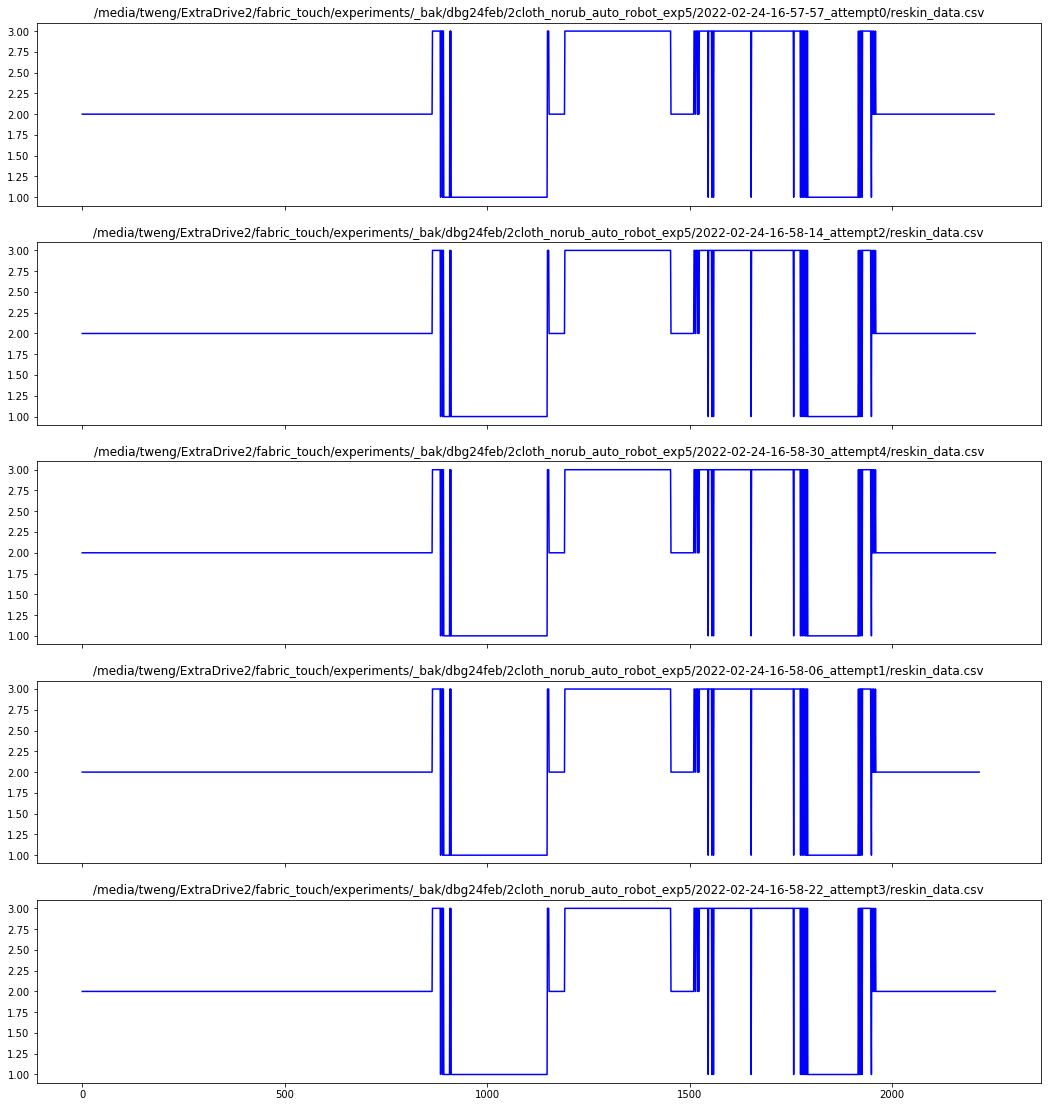

In [31]:
named_dict = create_plots_from_directory(fold_path, clf_path)


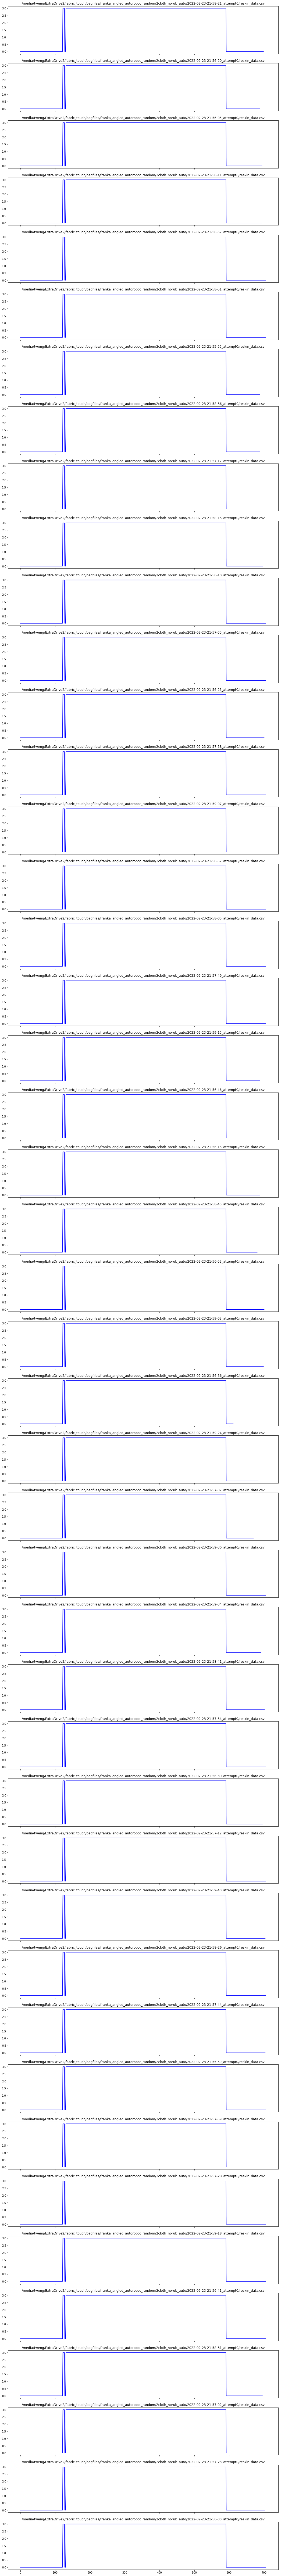

{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 'reskin_data':        Bx-Center    By-Center    Bz-Center       Bx-Top        By-Top  \
 0   -3264.379883 -2980.180176  4615.180176 -1715.000000 -12382.299805   
 1   -3262.419922 -2905.700195  4520.380371 -1793.399902 -12403.859375   
 2   -3206.560059 -2892.959961  4521.959961 -1809.079834 -12397.000000   
 3   -3236.939941 -3048.779785  4566.200195 -1784.579956 -12314.679688   
 4   -3299.660156 -3010.560059  4564.620117 -1764.000000 -12358.779297   
 5   -3234.979980 -2930.199951  4607.280273 -1690.500000 -12388.179688   
 6   -3326.120117 -2988.020020  4561.460449 

In [87]:
create_plots_from_named_dict(named_dict)



plot_variance_of_trials(df, "dbg")

('0: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp5/2022-02-24-16-57-57_attempt0/reskin_data.csv')
('1: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp5/2022-02-24-16-58-14_attempt2/reskin_data.csv')
('2: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp5/2022-02-24-16-58-30_attempt4/reskin_data.csv')
('3: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp5/2022-02-24-16-58-06_attempt1/reskin_data.csv')
('4: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp5/2022-02-24-16-58-22_attempt3/reskin_data.csv')


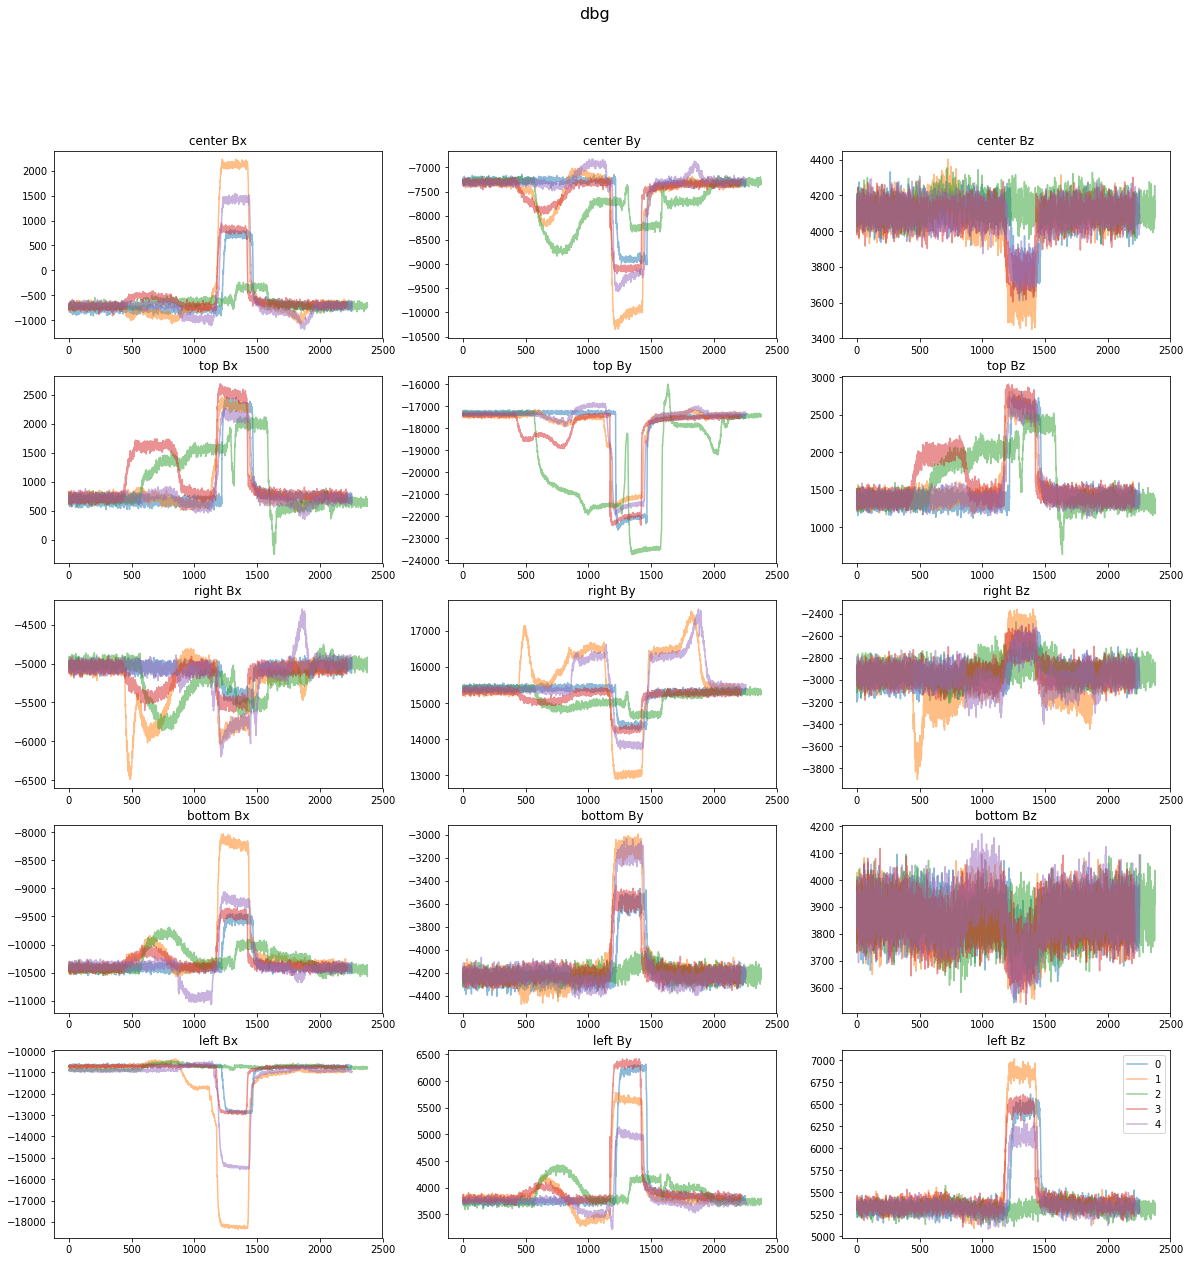

In [35]:
plot_variance_of_trials(df, "dbg")

('k: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp4/2022-02-24-16-53-56_attempt3/reskin_data.csv')
('k: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp4/2022-02-24-16-53-32_attempt0/reskin_data.csv')
('k: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp4/2022-02-24-16-53-48_attempt2/reskin_data.csv')
('k: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp4/2022-02-24-16-53-40_attempt1/reskin_data.csv')
('k: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp4/2022-02-24-16-54-05_attempt4/reskin_data.csv')


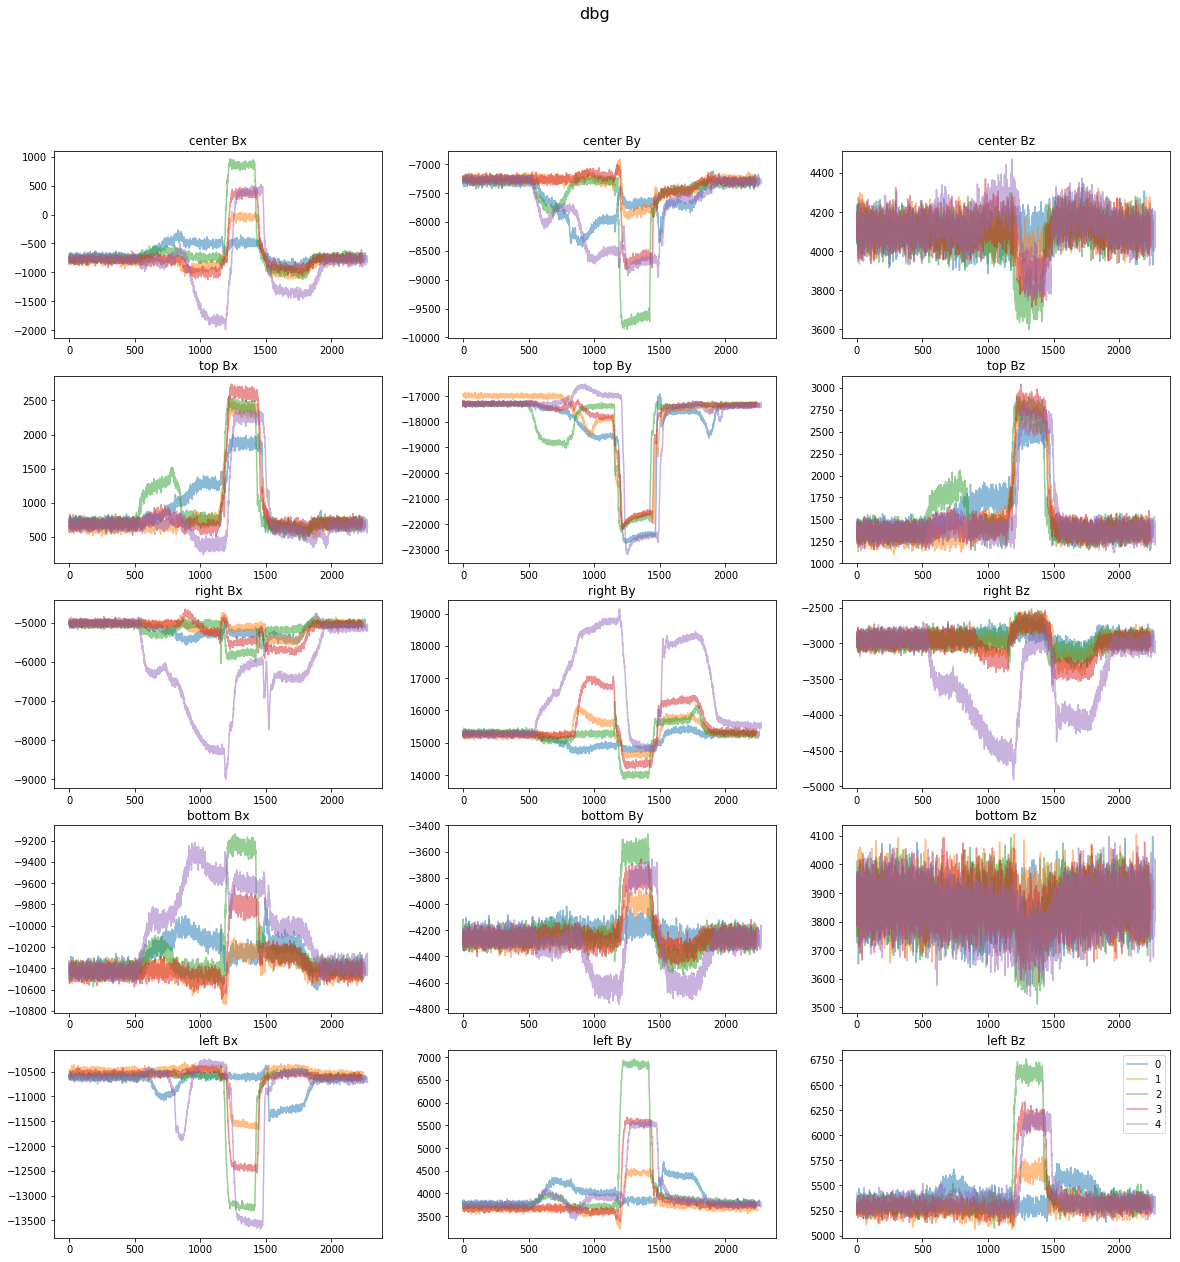

In [102]:
plot_variance_of_trials(df, "dbg")

In [10]:
import rosbag
bag = rosbag.Bag(bagpath)
topics = bag.get_type_and_topic_info()[1].keys()
print(topics)

['/classifier_commands', '/classifier_output', '/webcam_image', '/reskin']


('k: ', '/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp4/2022-02-24-16-53-32_attempt0/data.bag')


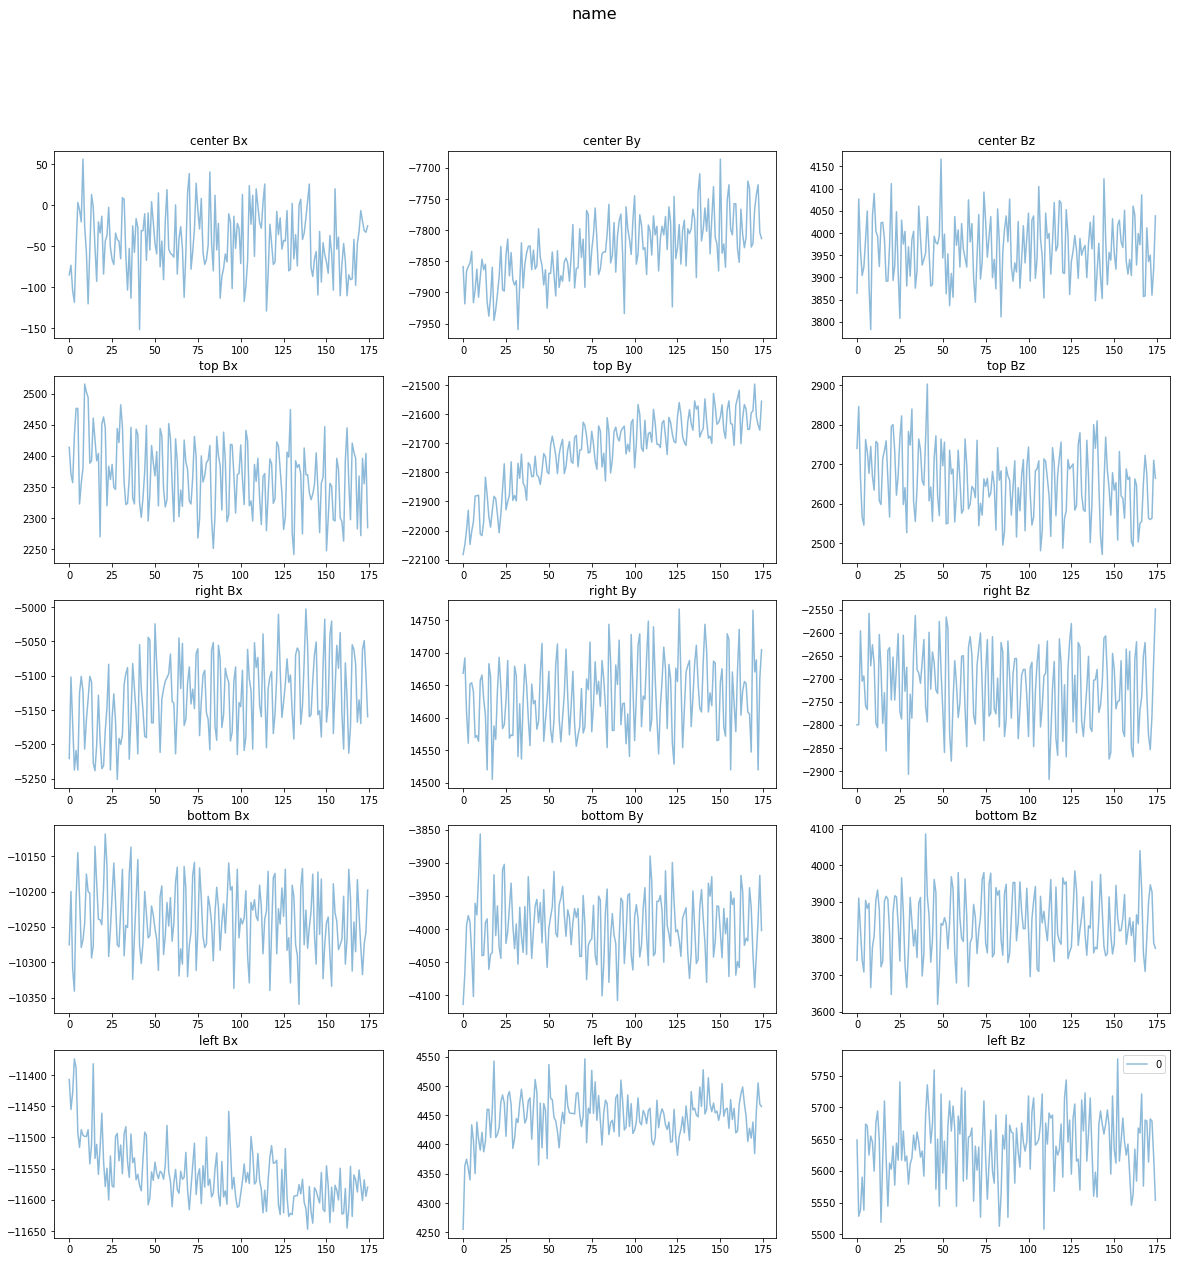

In [26]:
plot_variance_of_trials(reskin_dat, "name")

In [36]:
folder = "/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto"
train_reskin_data = get_all_reskin_data(folder)

('0: ', '/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto/2022-02-23-21-58-21_attempt0/reskin_data.csv')
('1: ', '/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto/2022-02-23-21-56-20_attempt0/reskin_data.csv')
('2: ', '/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto/2022-02-23-21-56-05_attempt0/reskin_data.csv')
('3: ', '/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto/2022-02-23-21-58-11_attempt0/reskin_data.csv')
('4: ', '/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto/2022-02-23-21-58-57_attempt0/reskin_data.csv')
('5: ', '/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto/2022-02-23-21-58-51_attempt0/reskin_data.csv')
('6: ', '/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2

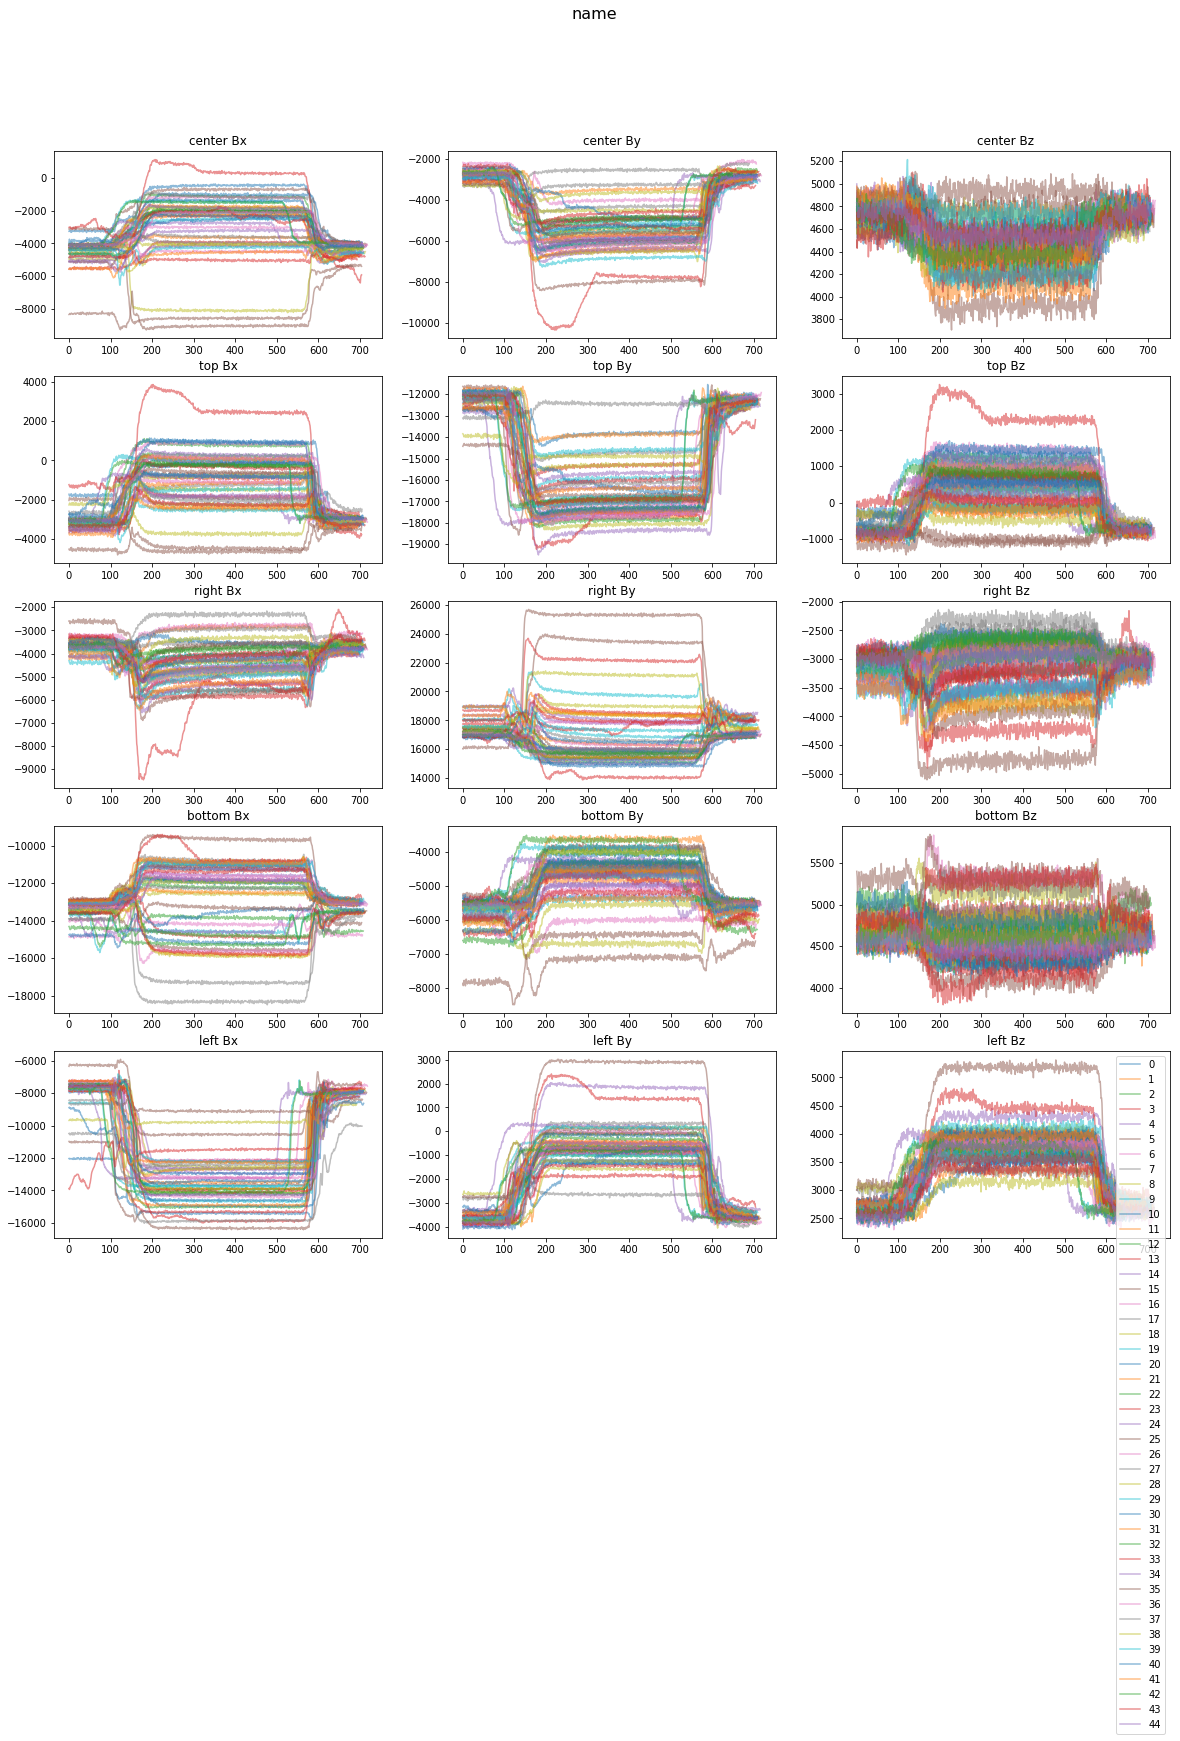

In [37]:
plot_variance_of_trials(train_reskin_data, "name", color="red")

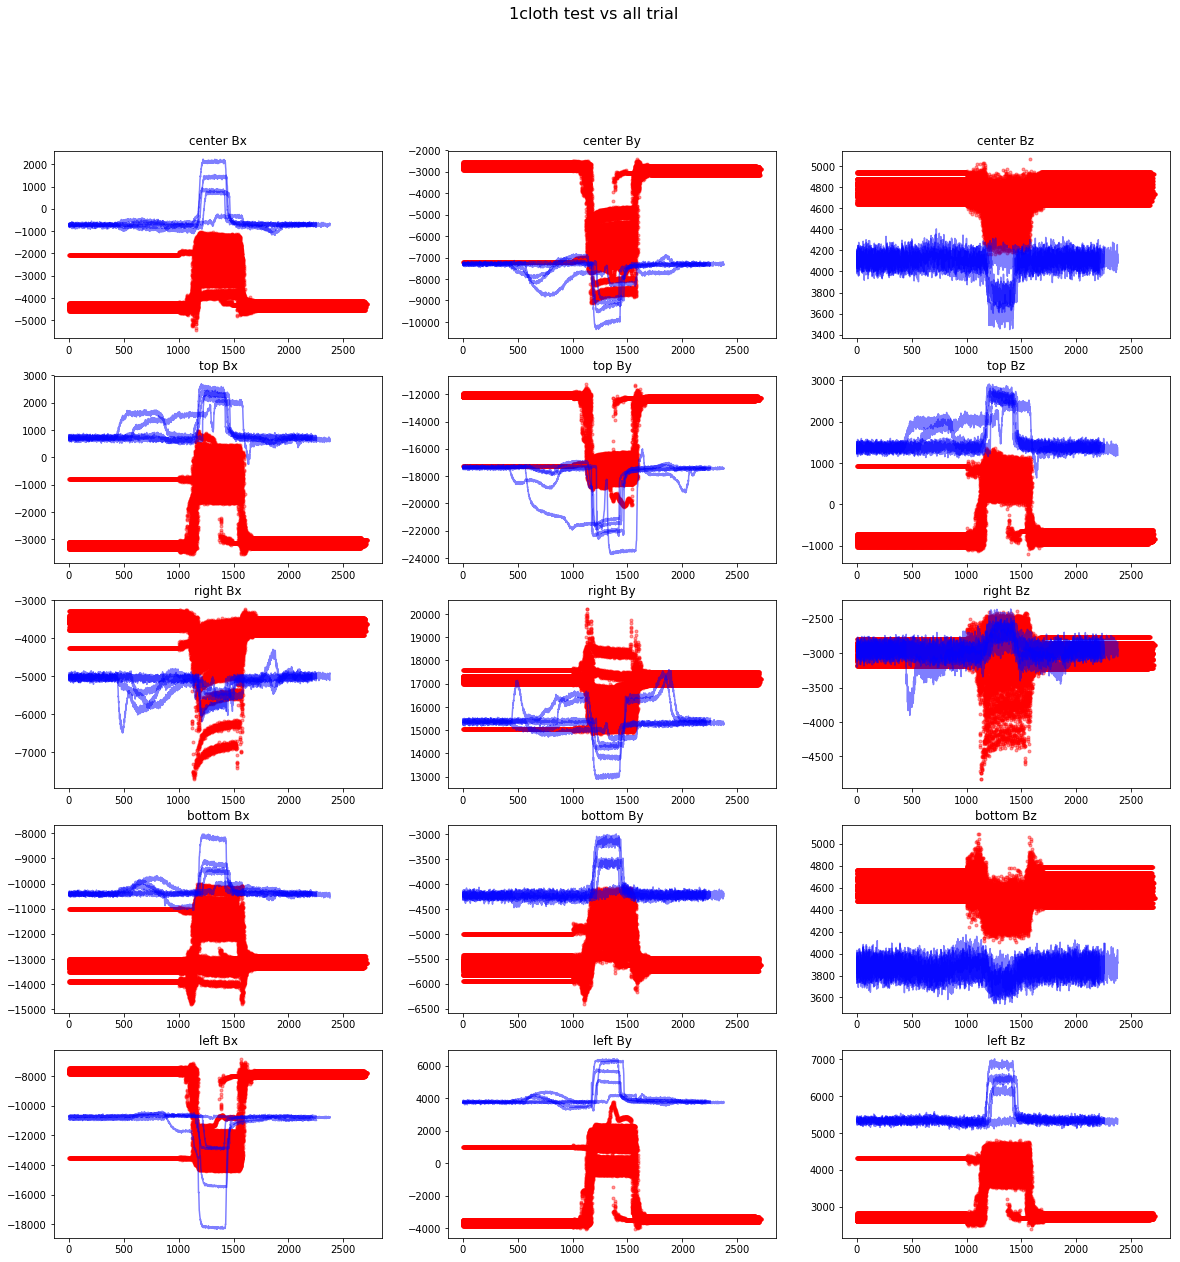

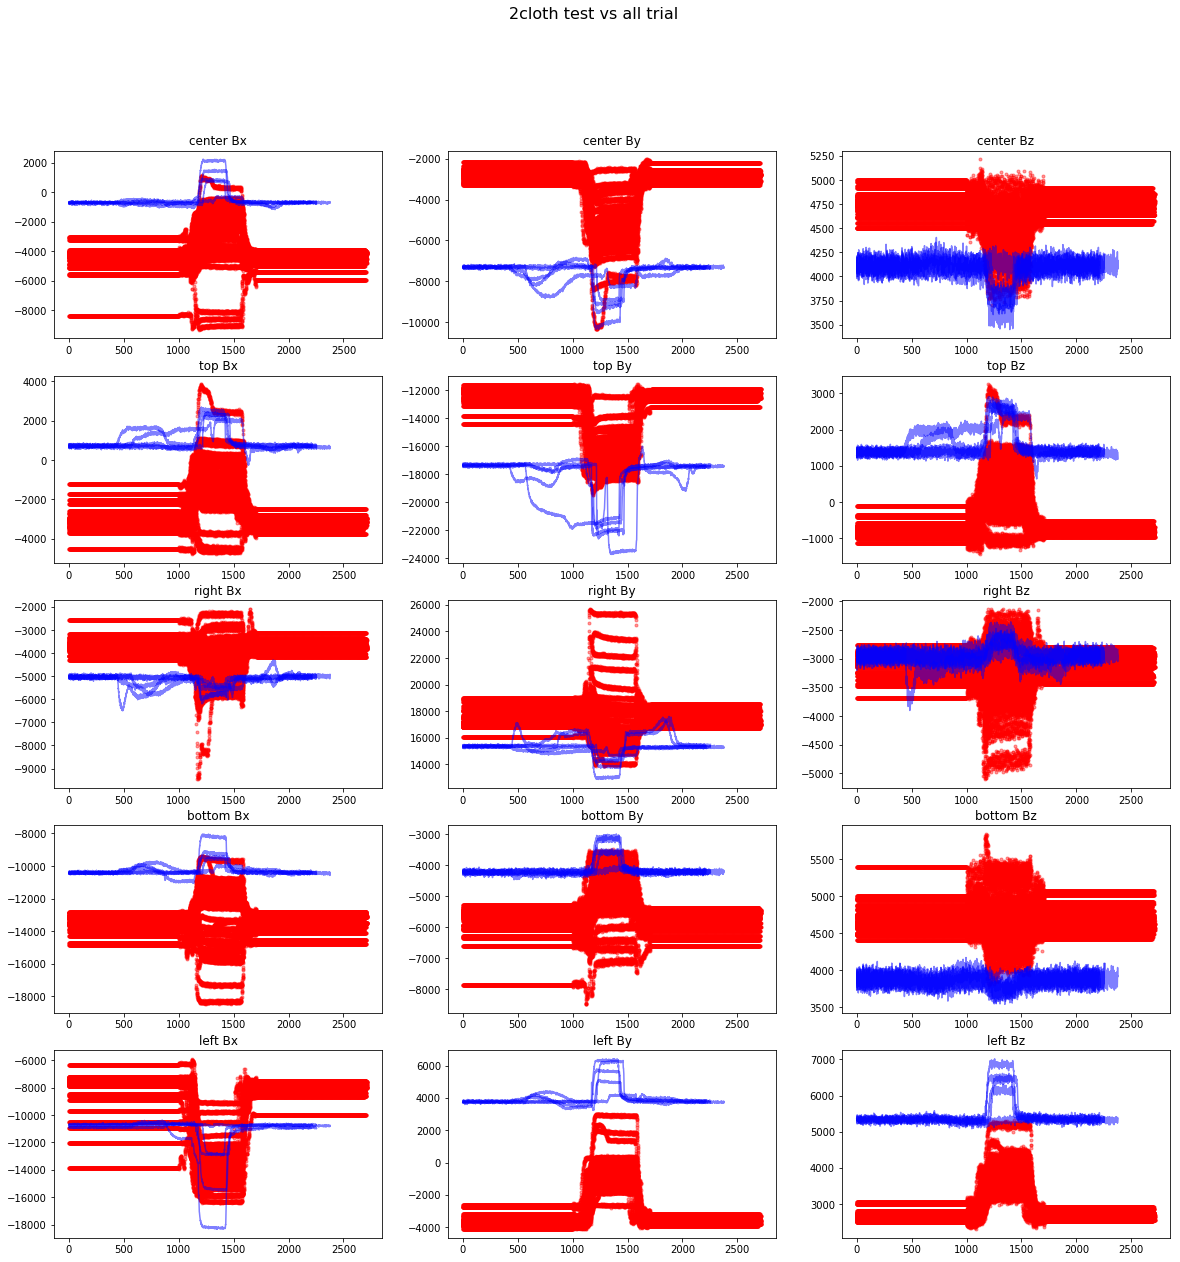

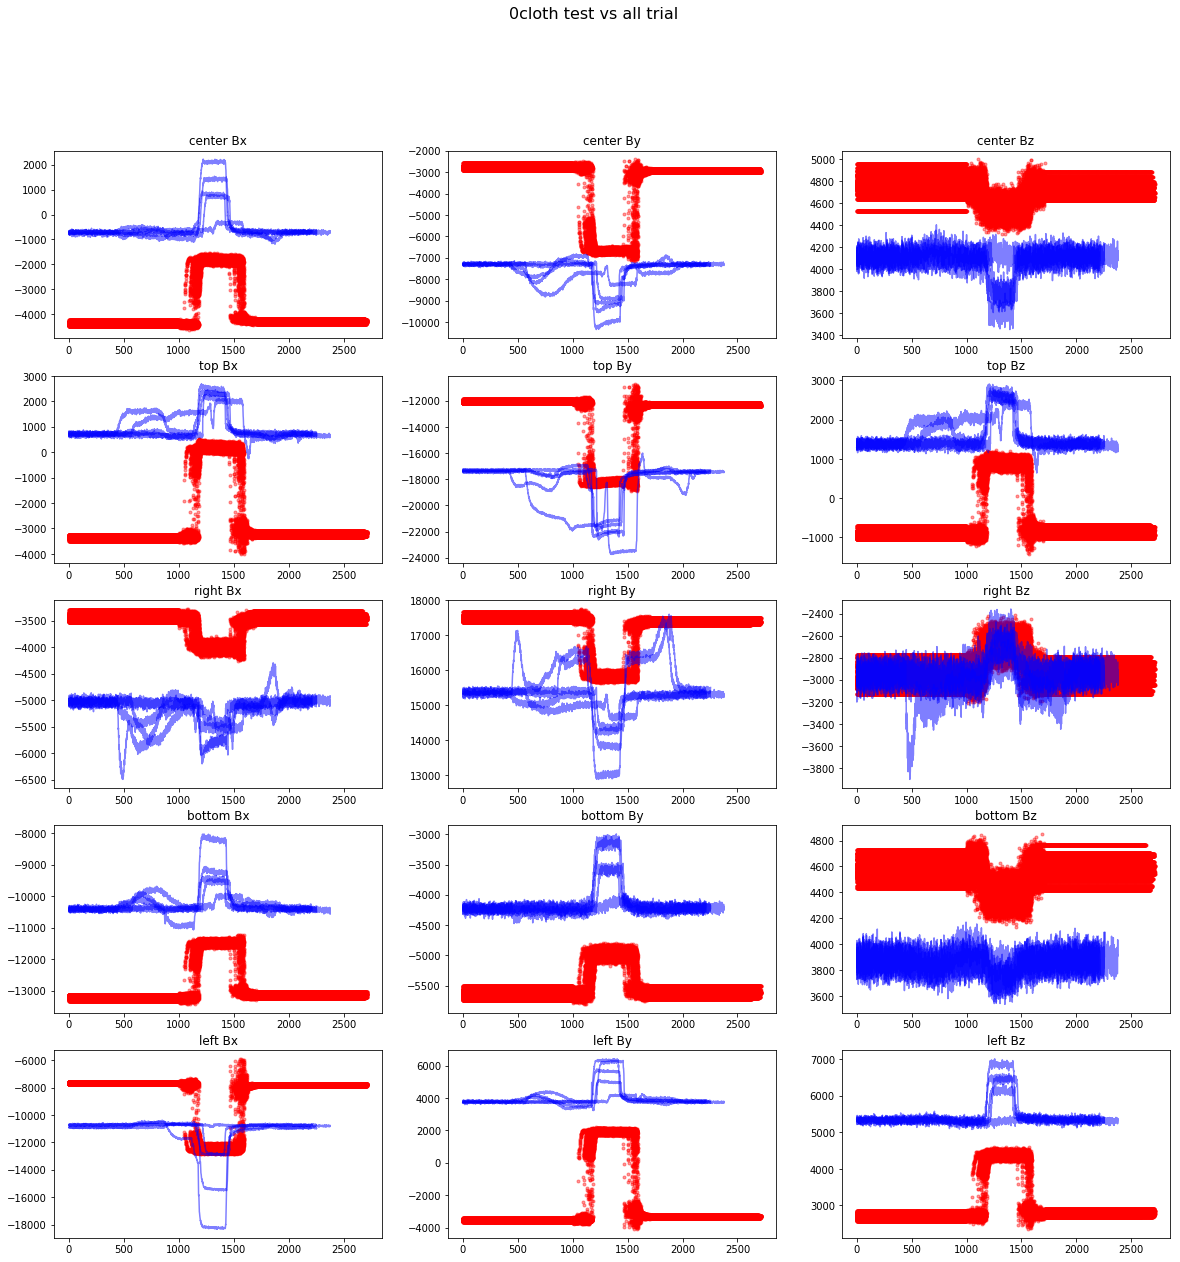

In [3]:
fold_path = "/media/tweng/ExtraDrive2/fabric_touch/experiments/_bak/dbg24feb/2cloth_norub_auto_robot_exp5"
test_reskin_data = get_all_reskin_data(fold_path)
folder = "/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/1cloth_norub_auto"
train_reskin_data = get_all_reskin_data(folder)

def plot_test_vs_train_trials(train_reskin_data, test_reskin_data, title):
    fig,axes = plt.subplots(5,3)
    unique_paths = train_reskin_data['path'].unique()
    for k in range(len(unique_paths)):
        cur_path = unique_paths[k]
        data = df_to_reskin_numpy_data(train_reskin_data, path=cur_path)
        for i in range(5):
            for j in range(3):
                axes[i,j].plot(np.pad(data[:,3*i+j], [1000,1000], "edge"),'r.', label = str(k), alpha = 0.4)
                axes[i,j].set_title(get_title(i,j))
    
    unique_paths = test_reskin_data['path'].unique()
    for k in range(len(unique_paths)):
        cur_path = unique_paths[k]
        data = df_to_reskin_numpy_data(test_reskin_data, path=cur_path)
        for i in range(5):
            for j in range(3):
                axes[i,j].plot(data[:,3*i+j],'b', label = str(k), alpha = 0.5)
        pass

    fig.set_size_inches(20, 20)
    fig.suptitle(title, fontsize=16)
#     for k in range(len(unique_paths)):
#         print(str(k)+": ", unique_paths[k])
    plt.show()
plot_test_vs_train_trials(train_reskin_data, test_reskin_data, "1cloth test vs all trial")
folder = "/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto"
train_reskin_data = get_all_reskin_data(folder)
plot_test_vs_train_trials(train_reskin_data, test_reskin_data, "2cloth test vs all trial")
folder = "/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/0cloth_norub_auto"
train_reskin_data = get_all_reskin_data(folder)
plot_test_vs_train_trials(train_reskin_data, test_reskin_data, "0cloth test vs all trial")

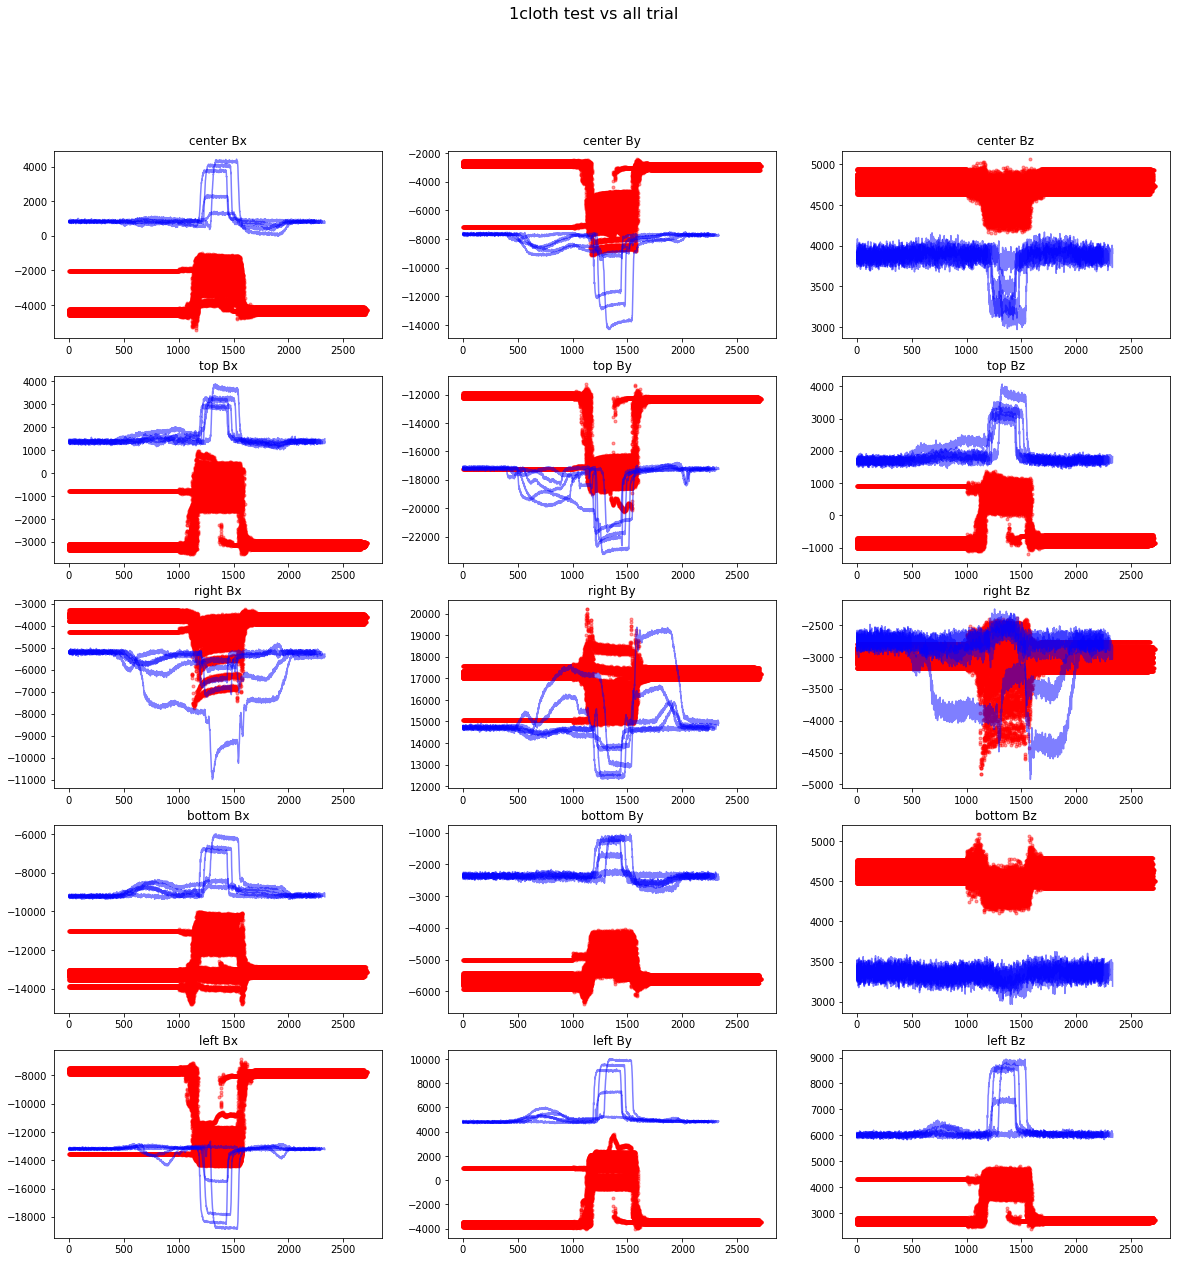

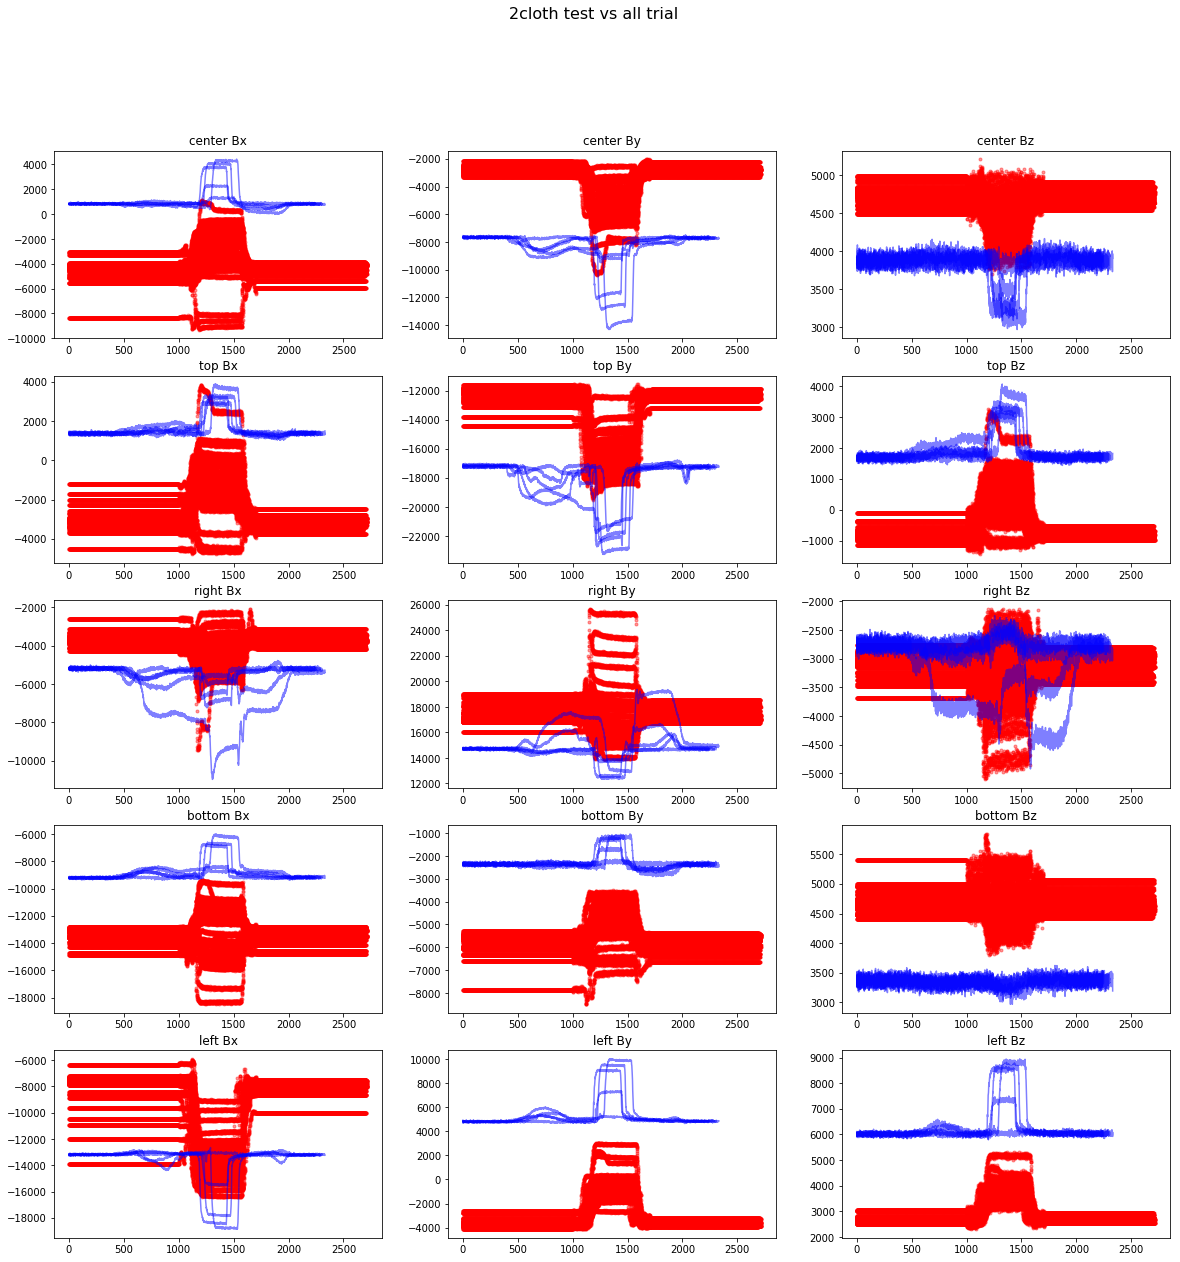

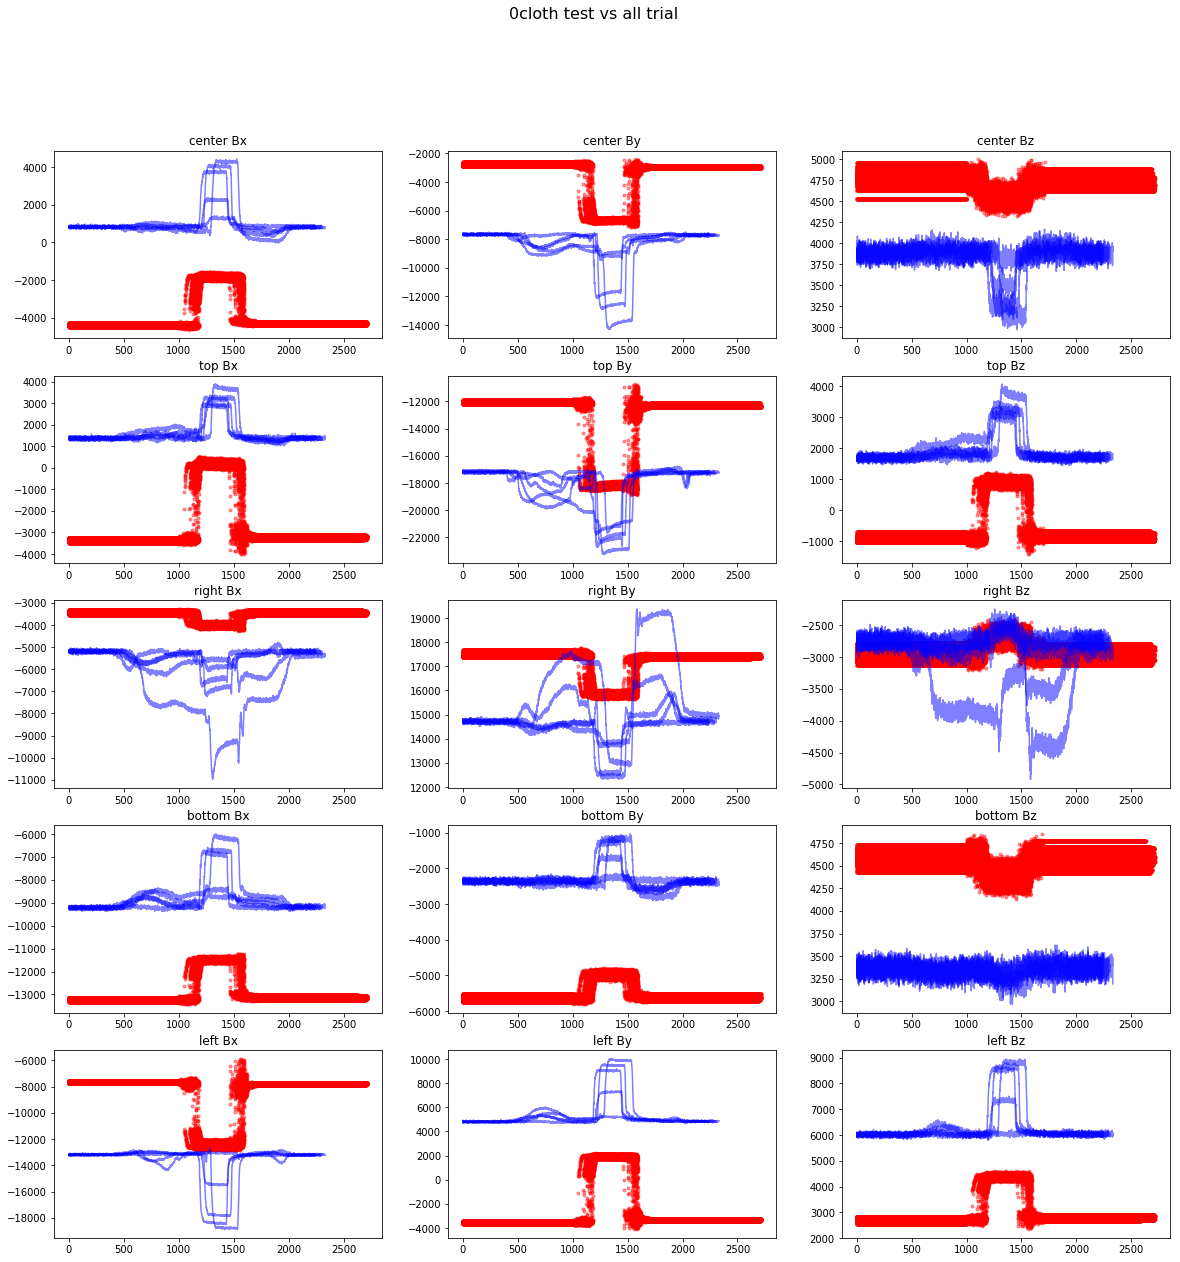

In [50]:
fold_path = "/media/tweng/ExtraDrive2/fabric_touch/paper_experiments/pilot/2022-02-24-21-04-24_simplevcomplex_closedlooponly_noterm/1cloth-simple-closedloop-tactile/2022-02-24-21-04-41_1cloth"
test_reskin_data = get_all_reskin_data(fold_path)
folder = "/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/1cloth_norub_auto"
train_reskin_data = get_all_reskin_data(folder)
plot_test_vs_train_trials(train_reskin_data, test_reskin_data, "1cloth test vs all trial")
folder = "/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/2cloth_norub_auto"
train_reskin_data = get_all_reskin_data(folder)
plot_test_vs_train_trials(train_reskin_data, test_reskin_data, "2cloth test vs all trial")
folder = "/media/tweng/ExtraDrive2/fabric_touch/bagfiles/franka_angled_autorobot_random/0cloth_norub_auto"
train_reskin_data = get_all_reskin_data(folder)
plot_test_vs_train_trials(train_reskin_data, test_reskin_data, "0cloth test vs all trial")

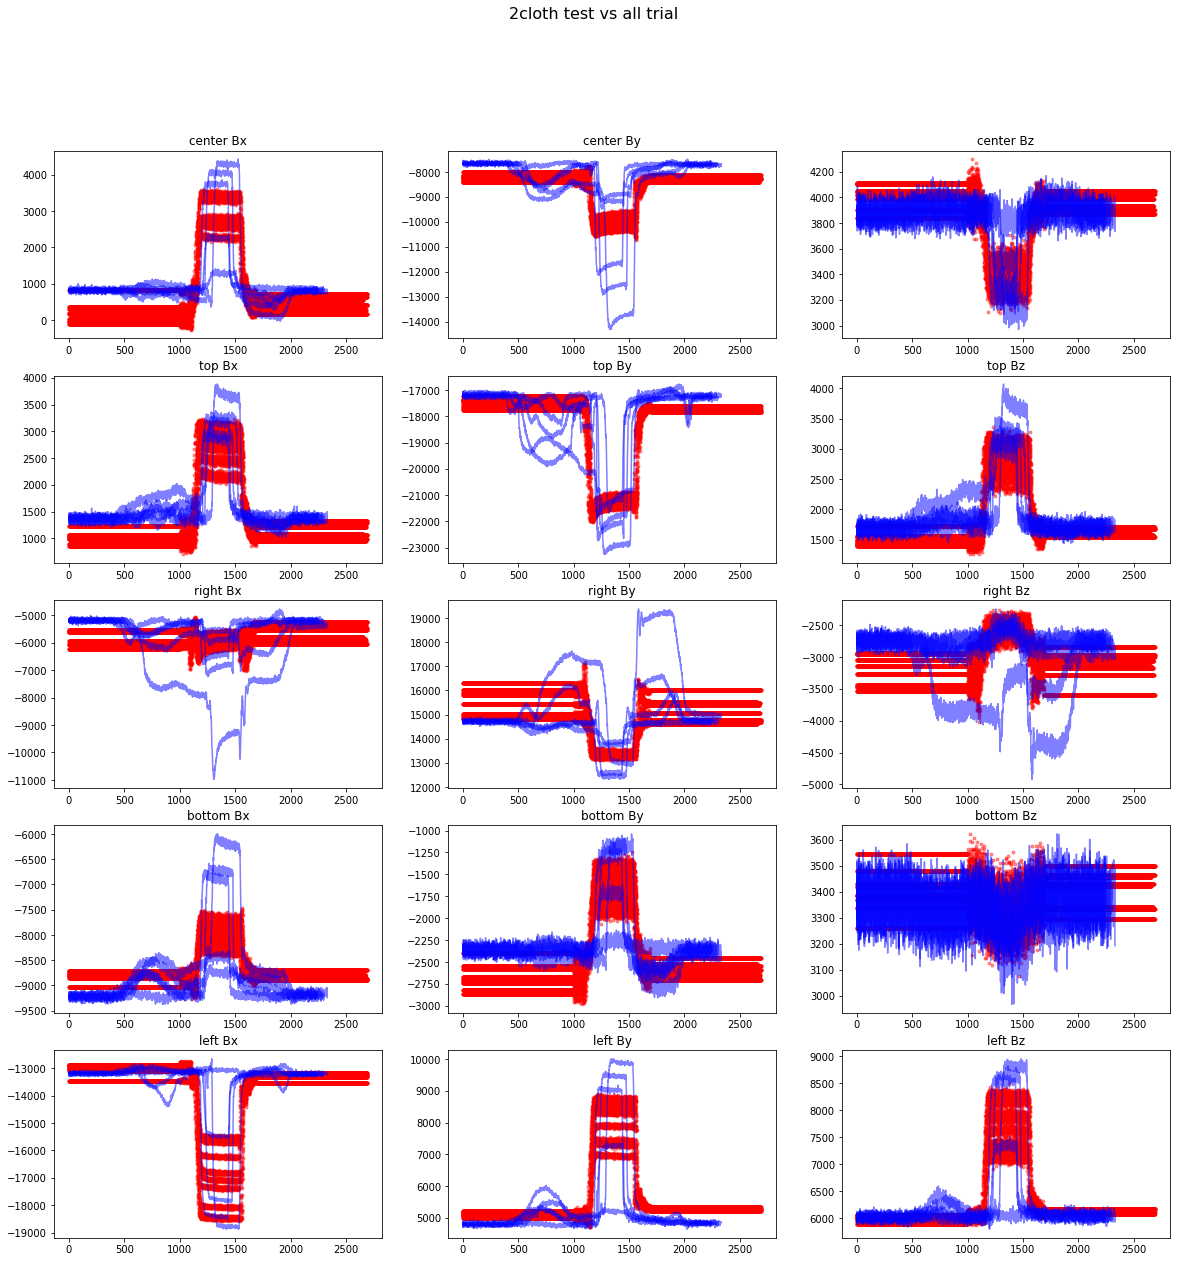

In [12]:
fold_path = "/media/tweng/ExtraDrive2/fabric_touch/paper_experiments/pilot/2022-02-24-21-04-24_simplevcomplex_closedlooponly_noterm/1cloth-simple-closedloop-tactile/2022-02-24-21-04-41_1cloth"
test_reskin_data = get_all_reskin_data(fold_path)
folder = "/media/ExtraDrive3/fabric_touch/bagfiles/angled_feb25/2cloth_norub_auto_robot"
folder = "/media/ExtraDrive3/fabric_touch/bagfiles/angled_feb25_edgeonly/2cloth_norub_auto_robot"

train_reskin_data = get_all_reskin_data(folder)
plot_test_vs_train_trials(train_reskin_data, test_reskin_data, "2cloth test vs all trial")

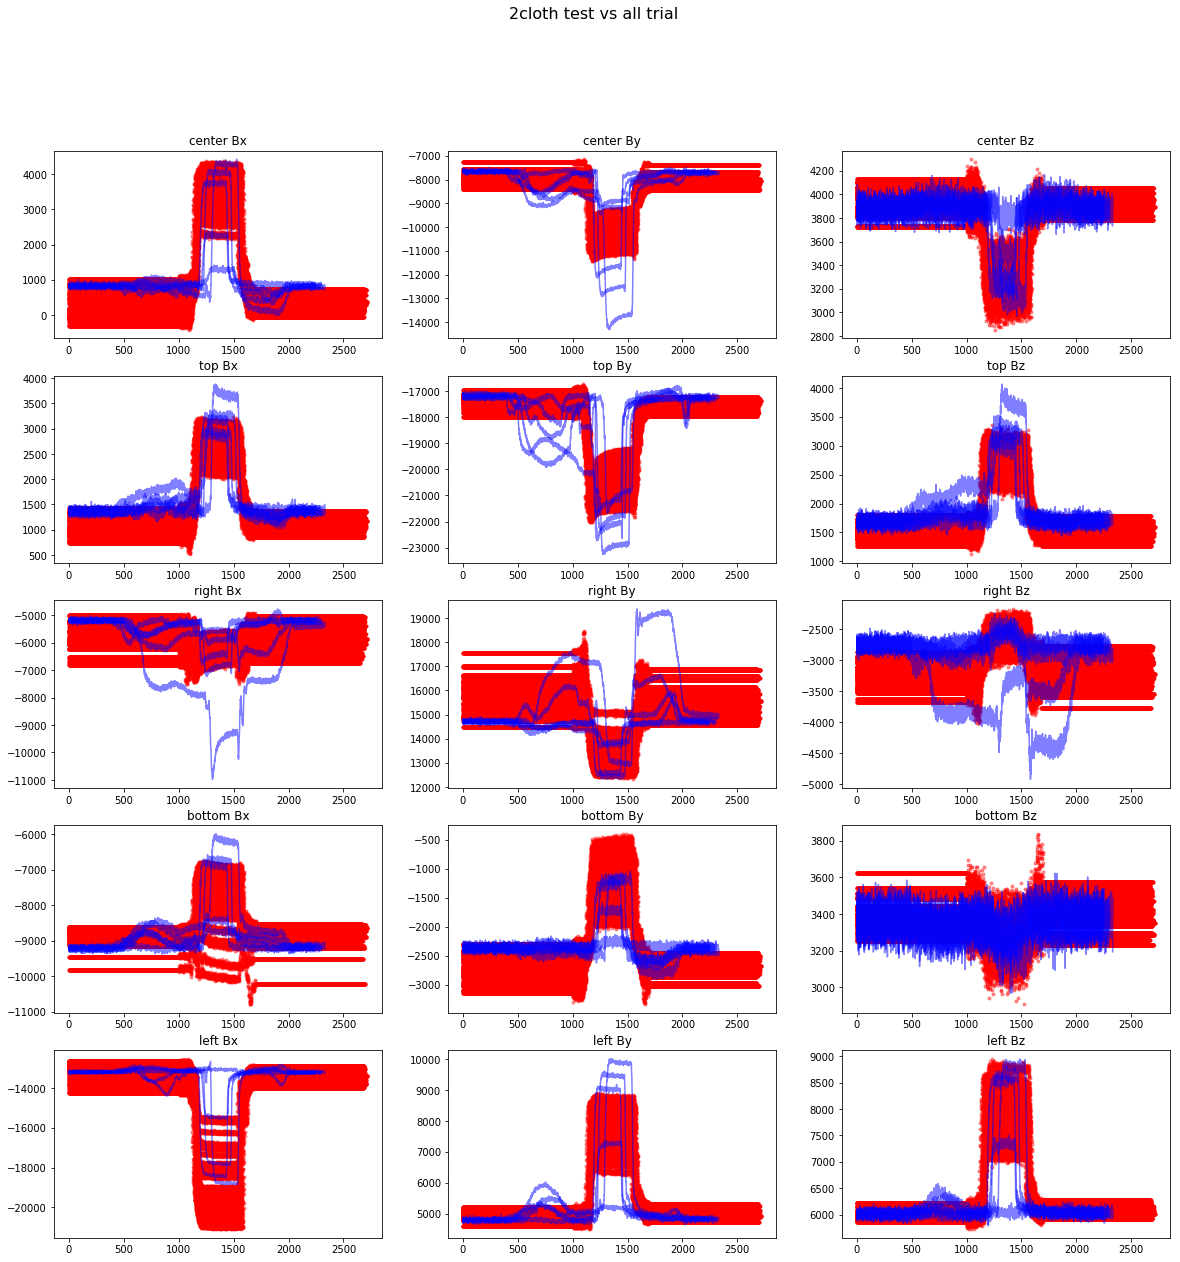

In [15]:
fold_path = "/media/tweng/ExtraDrive2/fabric_touch/paper_experiments/pilot/2022-02-24-21-04-24_simplevcomplex_closedlooponly_noterm/1cloth-simple-closedloop-tactile/2022-02-24-21-04-41_1cloth"
test_reskin_data = get_all_reskin_data(fold_path)
folder = "/media/ExtraDrive3/fabric_touch/bagfiles/angled_feb25/2cloth_norub_auto_robot"
# folder = "/media/ExtraDrive3/fabric_touch/bagfiles/angled_feb25_edgeonly/2cloth_norub_auto_robot"

train_reskin_data = get_all_reskin_data(folder)
plot_test_vs_train_trials(train_reskin_data, test_reskin_data, "2cloth test vs all trial")

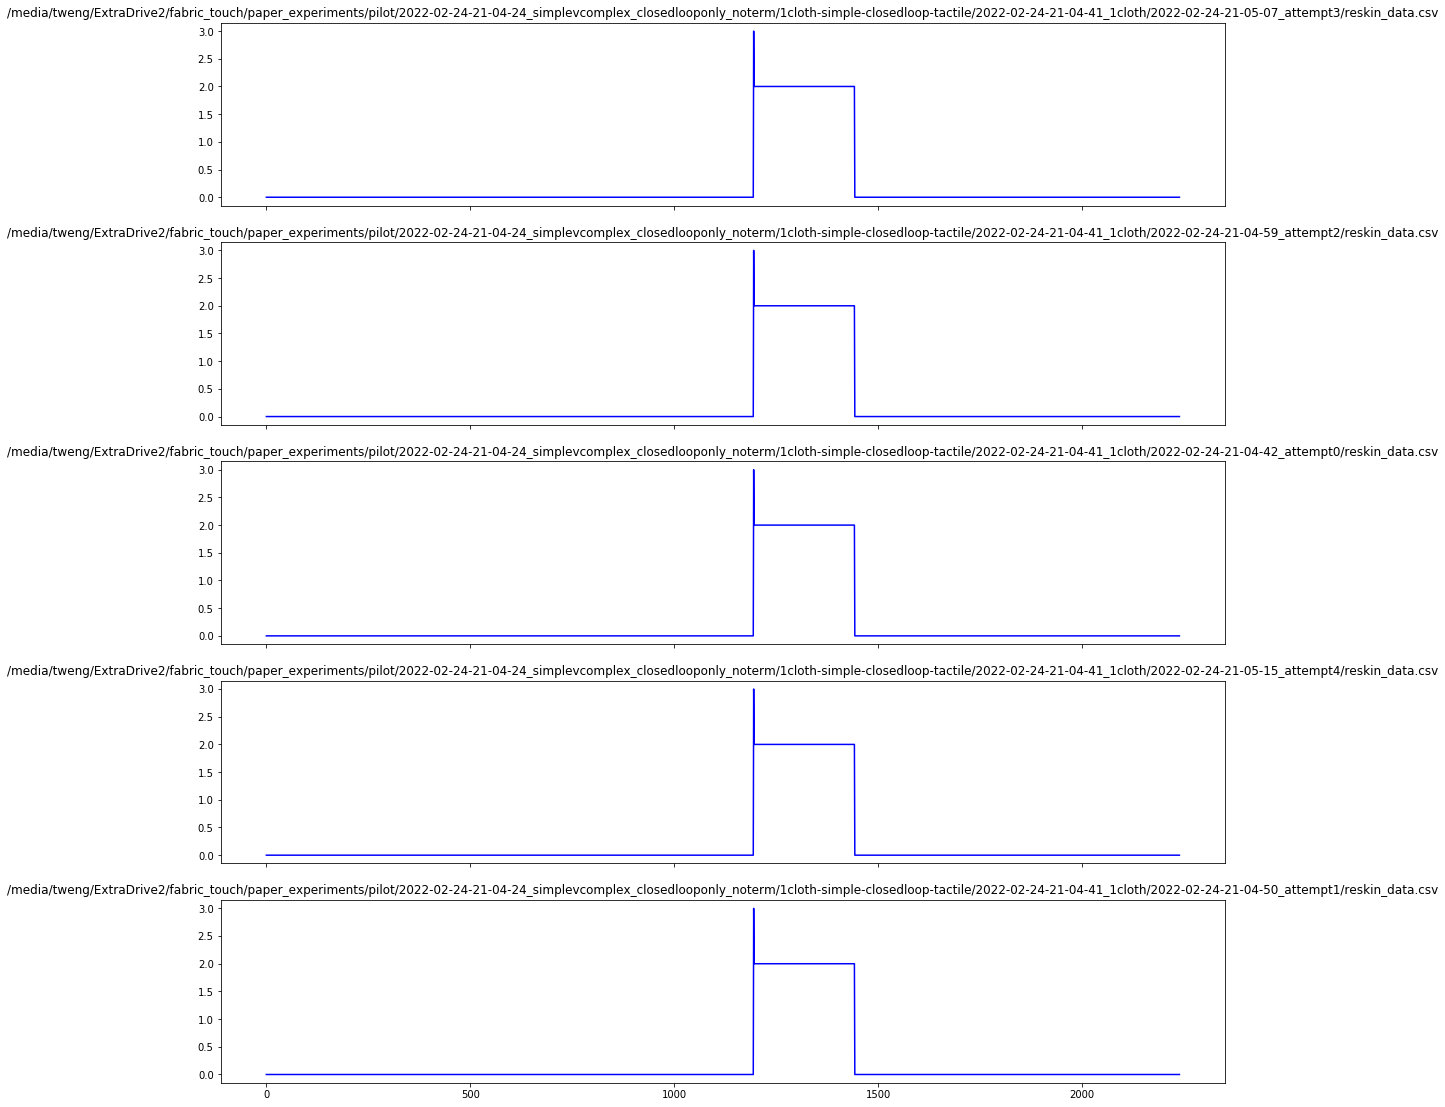

In [18]:
fold_path = "/media/tweng/ExtraDrive2/fabric_touch/paper_experiments/pilot/2022-02-24-21-04-24_simplevcomplex_closedlooponly_noterm/1cloth-simple-closedloop-tactile/2022-02-24-21-04-41_1cloth"
reskin_dat = get_all_reskin_data(fold_path)
clf_path = "/media/ExtraDrive3/fabric_touch/classifiers/3classes_90percent_data_25feb_auto_collect_franka_knn"
clf,scaler = load_clf_and_scaler_from_dir(clf_path)
df = evaluate_clf_on_reskin_trials(reskin_dat, clf, scaler, "name")
plot_clf_trial_data(df)

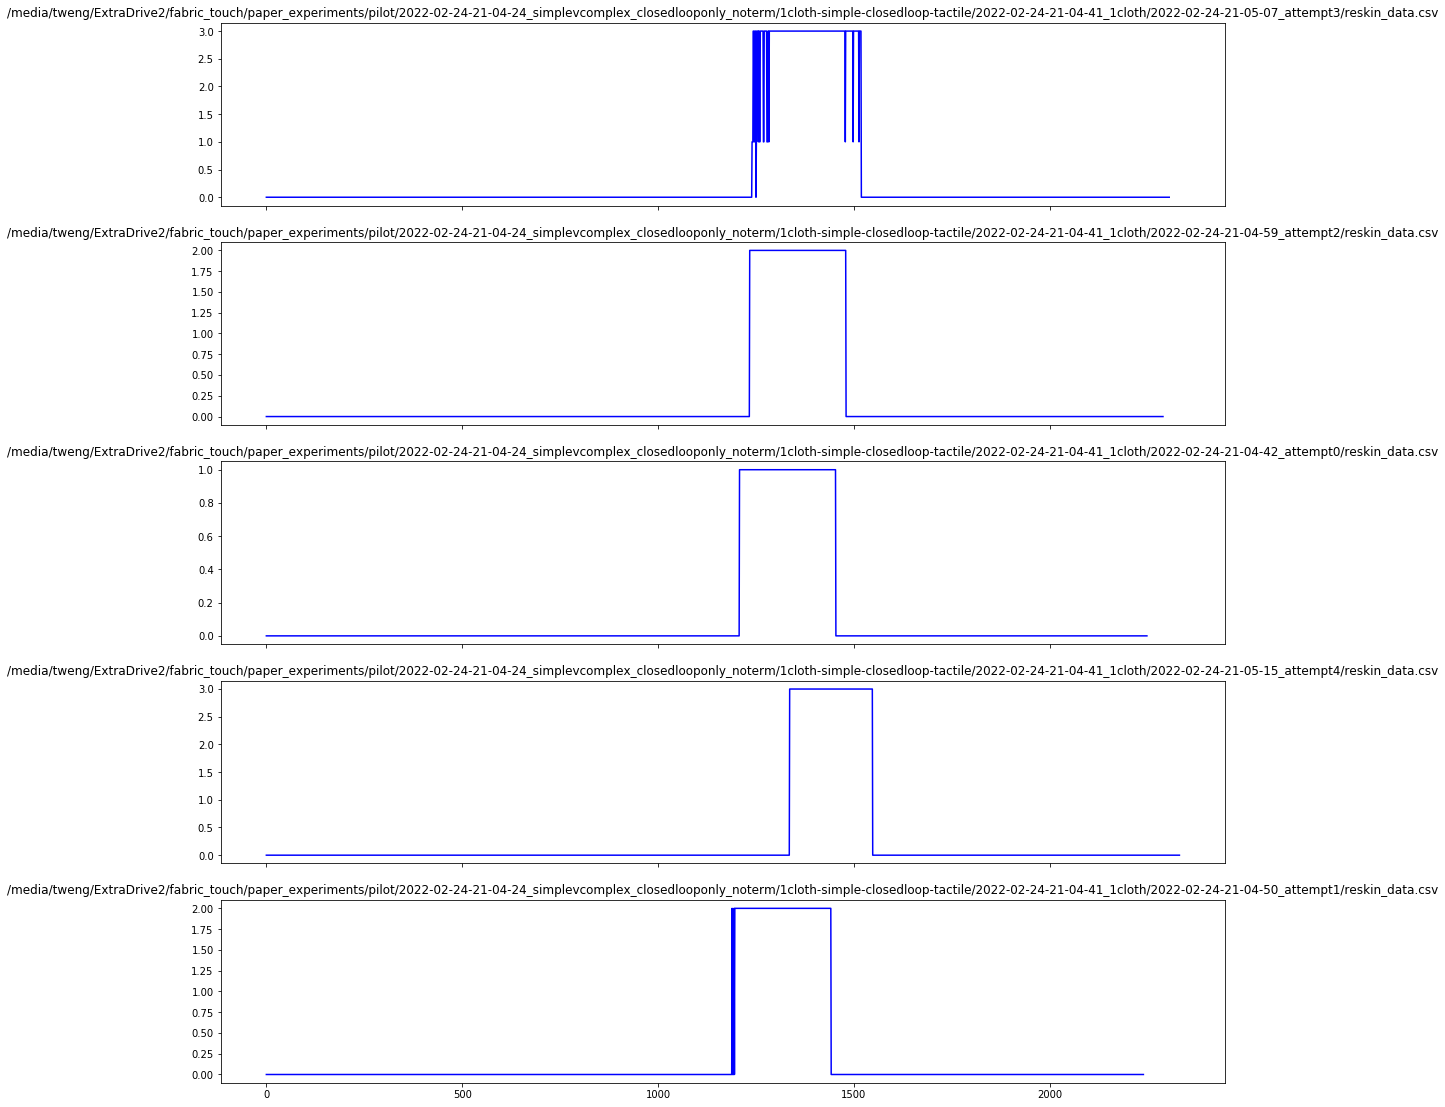

In [37]:
fold_path = "/media/tweng/ExtraDrive2/fabric_touch/paper_experiments/pilot/2022-02-24-21-04-24_simplevcomplex_closedlooponly_noterm/1cloth-simple-closedloop-tactile/2022-02-24-21-04-41_1cloth"
reskin_dat = get_all_reskin_data(fold_path)
clf_path = "/media/ExtraDrive3/fabric_touch/classifiers/4classes_angledfeb25all_90percent_svc"
clf,scaler = load_clf_and_scaler_from_dir(clf_path)
df = evaluate_clf_on_reskin_trials(reskin_dat, clf, scaler, "name")
plot_clf_trial_data(df)

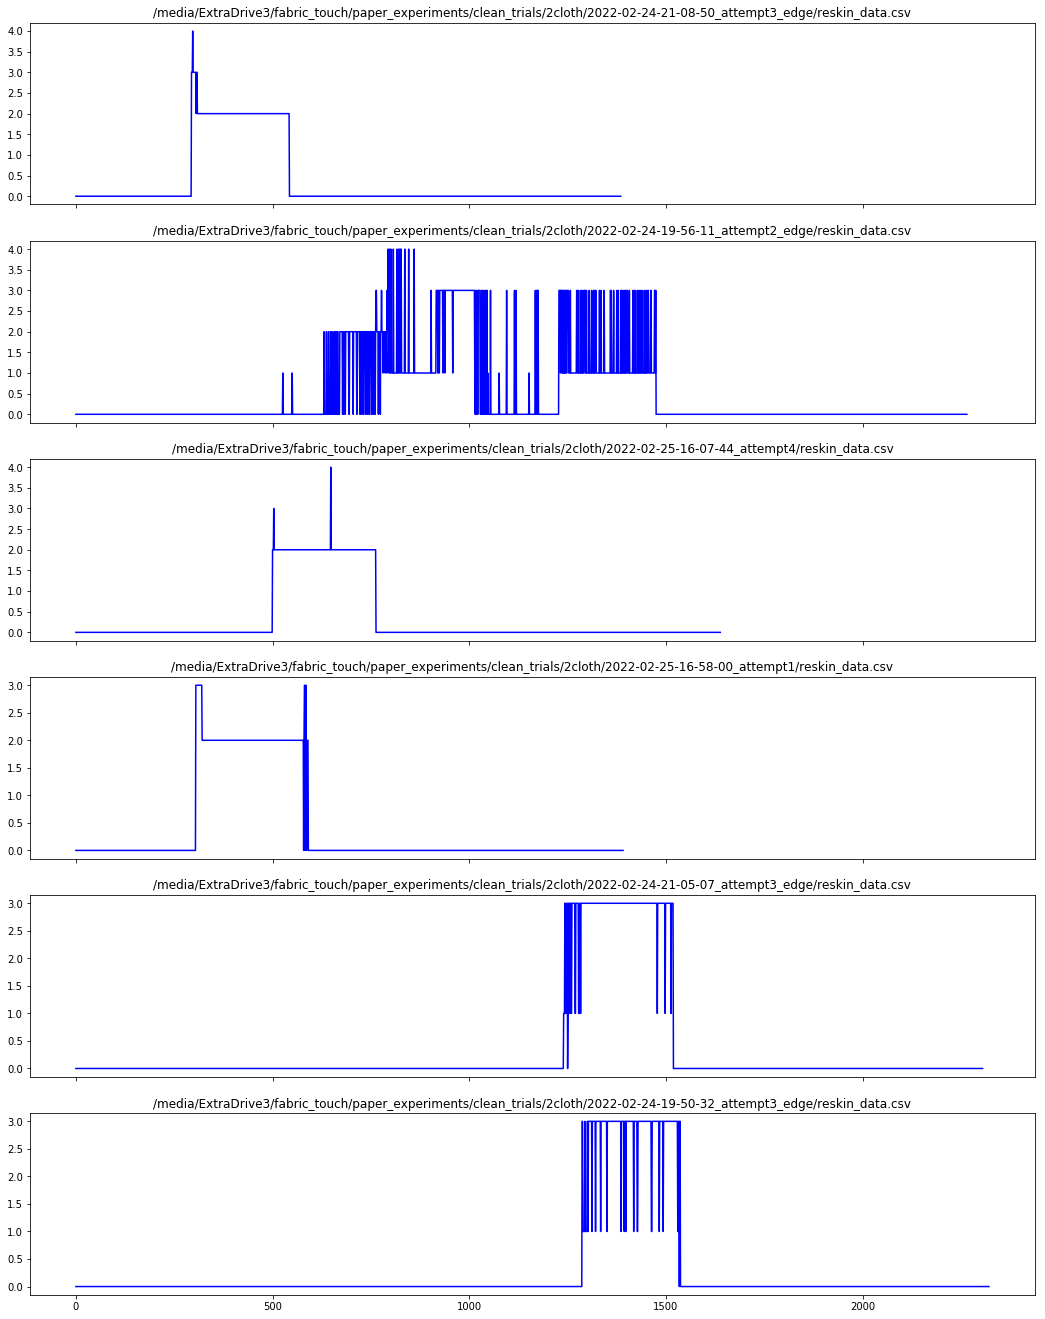

In [27]:
clf_path = "/media/ExtraDrive3/fabric_touch/classifiers/4classes_angledfeb25all_90percent_svc"
fold_path = "/media/ExtraDrive3/fabric_touch/paper_experiments/clean_trials/2cloth"

named_dict1 = create_plots_from_directory(fold_path, clf_path, sliced=True)